In [1]:
import numpy as np
import pandas as pd
import imblearn

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from collections import defaultdict

## Unakrsna validacija za neparametrizovane modele

In [2]:
%store -r X_final
%store -r y_final

In [3]:
np.random.seed(10)

In [4]:
X_final = X_final.astype('float64')
print('X shape: ', X_final.shape)
print('y shape: ', y_final.shape)

X shape:  (5910, 58)
y shape:  (5910,)


In [5]:
# redovi sa nedostajucim vrednostima
rows_to_remove = X_final[X_final.isna().any(axis=1)].index
rows_to_remove.shape

(912,)

In [6]:
def fit(X_with_all, attr_to_predict, curr_attr):
    X_with_all = pd.DataFrame(X_with_all)
    # izdvajamo ostale atribute kod kojih nema nedostajucih vrednosti (ali sa onim koji zelimo trenutno da predividimo)
    X = X_with_all.drop(columns=attr_to_predict.drop(curr_attr))

    # data - podaci ostalih atributa gde su za onaj koji zelimo da predvidimo nan vrednosti
    data = X[X[curr_attr].isna()]
    data.shape

    X.dropna(inplace=True) # izbacujemo nan vrednosti
    
    Q2 = np.median(X[curr_attr])
    Q1 = np.quantile(X[curr_attr], 0.25)
    Q3 = np.quantile(X[curr_attr], 0.75)
    
    IQR = Q3 - Q1 

    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR

    #print('lower_limit: ', lower_limit)
    #print('upper_limit: ', upper_limit)

    # Izbacicemo sve koji imaju vrednosti vecu od upper_limit i manju od lower_limit
    ind = X[(X[curr_attr] > upper_limit)].index
    ind2 = X[(X[curr_attr] < lower_limit)].index

    X.drop(index=ind, inplace=True)
    X.drop(index=ind2, inplace=True)

    X_train = X.drop(curr_attr, axis=1)
    y_train = X[curr_attr]

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    regressor = XGBRegressor()
    regressor.fit(X_train, y_train)

    return regressor, scaler

In [7]:
def fit_regressors(X, attr_to_predict):
    regressors = []
    scalers = []
    for attr in attr_to_predict:
        regressor, scaler = fit(X, attr_to_predict, attr)
        regressors.append(regressor)
        scalers.append(scaler)
    
    return regressors, scalers

In [8]:
def predict(X_with_all, attr_to_predict, curr_attr, regressor, scaler):
    X_with_all = pd.DataFrame(X_with_all)
    
    # izdvajamo ostale atribute kod kojih nema nedostajucih vrednosti (ali sa onim koji zelimo trenutno da predividimo)
    X = X_with_all.drop(columns=attr_to_predict.drop(curr_attr))

    # data - podaci ostalih atributa gde su za onaj koji zelimo da predvidimo nan vrednosti
    data = X[X[curr_attr].isna()]

    X_to_pred = data.drop(columns=curr_attr)
    scaler.transform(X_to_pred)
    X_predicted = regressor.predict(X_to_pred)

    X1 = pd.DataFrame(X_with_all[X_with_all[curr_attr].isna()])
    X1[curr_attr] = X_predicted
    
    X2 = X_with_all[X_with_all[curr_attr].notna()]
    return pd.concat([X1, X2], axis=0)

In [9]:
def predict_attr(X, attr_to_predict, regressors, scalers):
    for attr, regressor, scaler in zip(attr_to_predict, regressors, scalers):
        X = predict(X, attr_to_predict, attr, regressor, scaler)
    
    return X

In [10]:
def delete_rows_with_missing_values(X, y):
    #izbacicujemo redove u kojima ima nedostajucih vrednosti
    # ovaj metod ce biti koriscen u slucaju kada ne zelimo da predvidjamo atribute
    rows_to_remove = X[X.isna().any(axis=1)].index
    
    X = X.drop(index=rows_to_remove)
    X.reset_index(inplace=True, drop=True)
    y = y.drop(index=rows_to_remove)
    y.reset_index(inplace=True, drop=True)

    return X, y

In [11]:
def cross_val(X, y, with_pred_values: bool, n_splits):
    # with_pred_values promneljivom se odredjuje da li zelimo da se predvide odredjeni atributi ili ne
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True)
    accuracy_scores = defaultdict(list)
    confusion_matrixs = defaultdict(list)

    
    classifiers = {
       'Logistic regression' : {
           'class' : LogisticRegression,
           'args' : {
               'solver' : 'lbfgs', 
               'max_iter' : 300, 
               'random_state' : 42
               }
           },
       'C-Support Vector' : {
           'class' : SVC,
           'args' : {
               'gamma' : 'auto', 
               'random_state' : 42
               }
           },
       'XGBClassifier' : {
           'class' : XGBClassifier,
           'args' : {
               'use_label_encoder' : False, 
               'random_state' : 42,
               'eval_metric' : 'rmse'
               }
           },
        'Neural Network' : {
            'class' : MLPClassifier,
            'args' : {
                'hidden_layer_sizes': (32,32,8),
                'max_iter': 300,
                'solver': 'adam',
                'activation': 'relu',
                'random_state' : 1,
            }
        }
    }
    
    attr_to_predict = X.isna().sum().sort_values(ascending=False).head(3).index

    if(not with_pred_values):
        X, y = delete_rows_with_missing_values(X, y)
    else:
        # predvidecemo prva 3 atributa sa najvise nedostajucih vrednosti
        # za ostale atribute, brisemo redove u kojima se nalaze nedostajuce vrednosti
        attr_to_predict = X.isna().sum().sort_values(ascending=False).head(3).index
        attr_to_delete_rows = X.isna().sum().sort_values(ascending=True).head(-3).index
        
        rows_to_remove = X[X[attr_to_delete_rows].isna().any(axis=1)].index
        X = X.drop(index=rows_to_remove)
        y = y.drop(index=rows_to_remove)
        X.reset_index(inplace=True, drop=True)
        y.reset_index(inplace=True, drop=True)


    for train_indexes, test_indexes in kf.split(X, y):
        # izdvajamo instance skupa za treniranje
        X_train = X.loc[train_indexes]
        y_train = y[train_indexes]
        # izdvajamo instance skupa za testiranje
        X_test = X.loc[test_indexes]
        y_test = y[test_indexes]

        if(with_pred_values):
            # na trening skupu fit-ujemo regresore za svaki od atributa
            regressors, scalers = fit_regressors(X_train, attr_to_predict)
            
            X_train = predict_attr(X_train, attr_to_predict, regressors, scalers)
            X_test = predict_attr(X_test, attr_to_predict, regressors, scalers)

        # pripremamo podatke
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_train)
        X_train_transformed = scaler.transform(X_train)
        X_test_transformed = scaler.transform(X_test)

        # balansiranje podataka
        smote = imblearn.over_sampling.SMOTE(random_state=0, k_neighbors=5)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)
              
        for classifier_name, classifier_config in classifiers.items():
            model_class = classifier_config['class']
            model_args = classifier_config['args']
            model = model_class(**model_args)
           
            # obučavamo model na pripremljenom skupu za treniranje
            #print("processing ", classifier_name[i])
            model.fit(X_train_resampled, y_train_resampled)
            
            # i evaluiramo model na pripremljenom skupu za testiranje
            score = metrics.accuracy_score(y_test, model.predict(X_test_transformed))
            accuracy_scores[classifier_name].append(score)

            matrix = metrics.confusion_matrix(y_test, model.predict(X_test_transformed))
            confusion_matrixs[classifier_name].append(matrix)
    
    score_mean = defaultdict(list)
    confusion_matrixs_mean = defaultdict(list)
    for classifier_name, _ in classifiers.items():
        score_mean[classifier_name] = np.array(accuracy_scores[classifier_name]).mean()
        confusion_matrixs_mean[classifier_name] = np.array(confusion_matrixs[classifier_name]).mean(axis=0)

    return score_mean, confusion_matrixs_mean

In [12]:
n_splits = 3
scores_with_pred_attr, matrix_with_pred_attr = cross_val(X_final, y_final, True, n_splits)
scores_without_pred_attr, matrix_without_pred_attr = cross_val(X_final, y_final, False, n_splits)

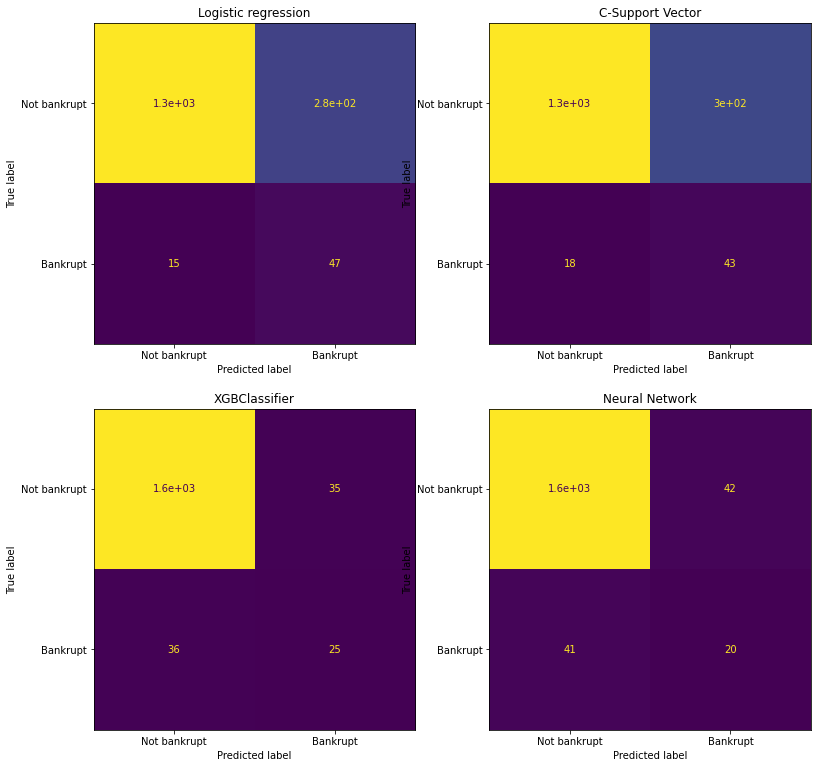

In [13]:
plt.figure(figsize=(13,13))
plt.title('Confusion matrix')

for i, (classifier_name, confusion_matrix) in enumerate(matrix_without_pred_attr.items()):
    ax = plt.subplot(2, 2, i+1)
    metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=['Not bankrupt', 'Bankrupt']).plot(ax=ax, colorbar=False)

    plt.title(classifier_name)

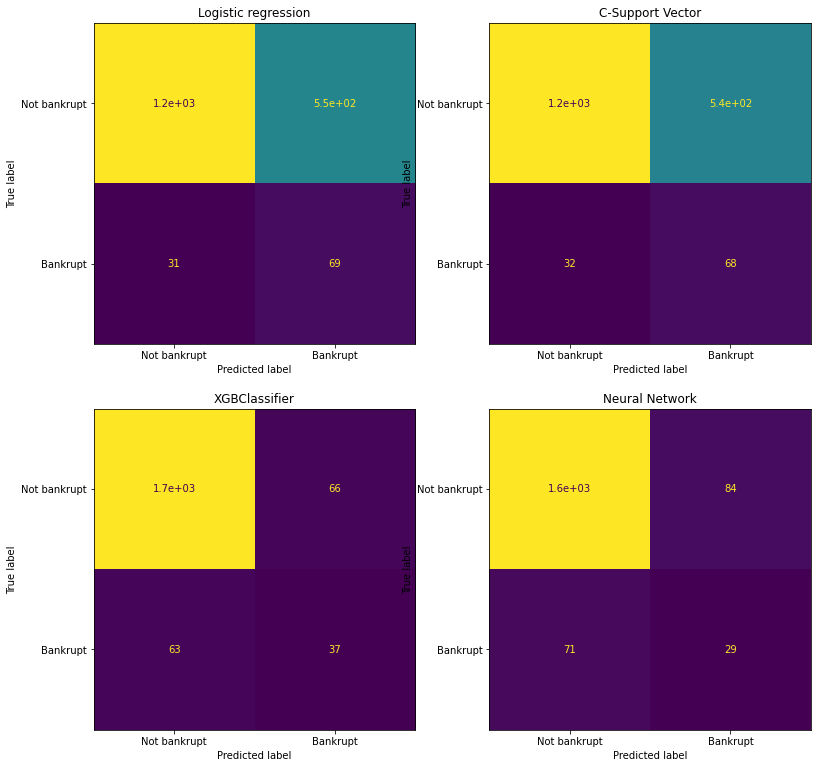

In [14]:
plt.figure(figsize=(13,13))
plt.title('Confusion matrix')

for i, (classifier_name, confusion_matrix) in enumerate(matrix_with_pred_attr.items()):
    ax = plt.subplot(2, 2, i+1)
    metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=['Not bankrupt', 'Bankrupt']).plot(ax=ax, colorbar=False)

    plt.title(classifier_name)

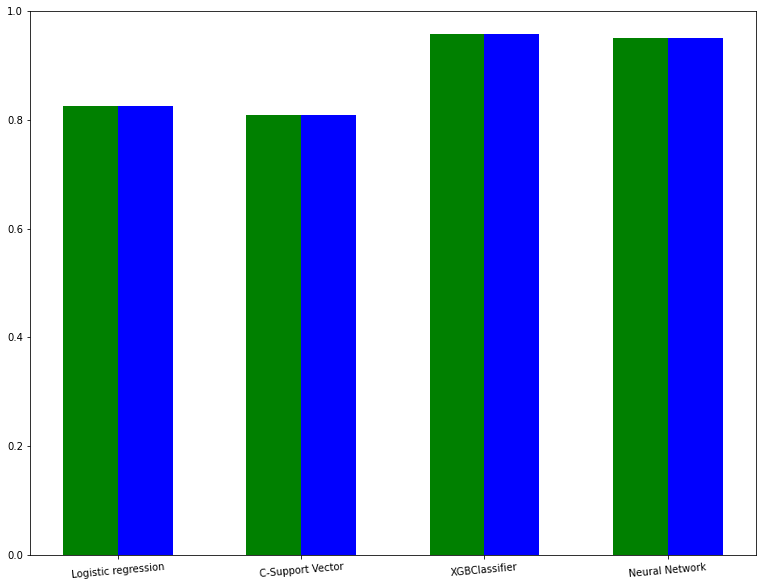

In [15]:
n = len(scores_without_pred_attr)

plt.figure(figsize=(13, 10))
i=0
for classifier_name, classifier_item in scores_without_pred_attr.items():
    plt.bar(i+0.15, scores_with_pred_attr[classifier_name], color='blue', width=0.3)
    plt.bar(i-0.15, scores_without_pred_attr[classifier_name], color='green', width=0.3)
    i=i+1
    
plt.xticks(range(n), scores_without_pred_attr.keys(), rotation=5)
plt.ylim(0, 1)

plt.show()